# Neural Style Transfer

This notebook is one of the mini-project for DATA 2040. The algorithm is based on the paper writen by [Gatys et al.](https://arxiv.org/pdf/1508.06576.pdf). Some improvements are inspired by [Johnson el at.](https://arxiv.org/abs/1603.08155)'s paper which proposed a realtime style transfer. The fast version of style transfer is not covered in this notebook. There is a [blog post]() related to this notebook for detailed information.

### Notes for grading:

1. Changed the Dataset: We generated the image based on different content and style images.
2. Retrained the Model: We retrained the model based on gradient descent to generate the transfered style image for every pair of content and style
3. Added Layers or Changed architecture: In the original paper, they used VGG19 as the feature extraction and we changed it to VGG16 to improve the generated results. The idea of changing VGG19 to VGG16 is inspired by [Johnson el at.](https://arxiv.org/abs/1603.08155)'s work

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from keras import metrics
from keras.models import Model
from keras.applications import VGG16
import keras.backend as K
from skimage import io, img_as_float, transform
from keras.applications.vgg16 import preprocess_input
import os

Using TensorFlow backend.


## content and style image preprocessing

In [2]:
# Fix the size of the image to ensure the reasonable training time
width,length = 512, 512 

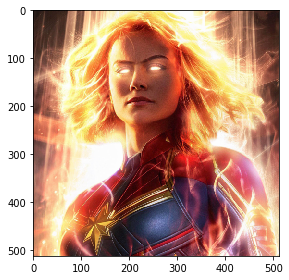

In [3]:
content = io.imread('content/Captain_marvel.jpeg')
content = transform.resize(content,(width, length))
content = (content*255).astype('uint8')
io.imshow(content)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


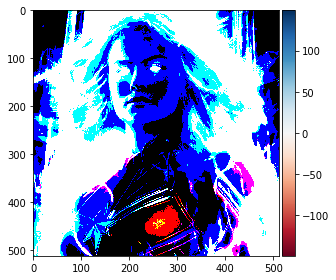

In [4]:
content = preprocess_input(content)
io.imshow(content)

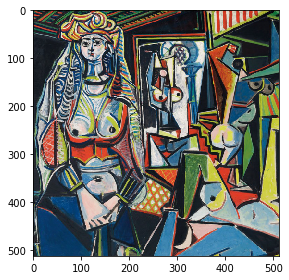

In [5]:
style = io.imread('style/Les.jpg')
style = transform.resize(style,(width, length))
style = (style*255).astype('uint8')
io.imshow(style)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


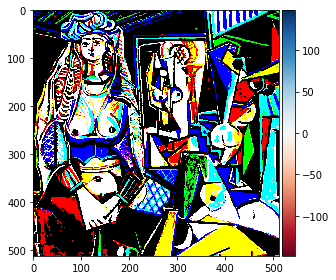

In [6]:
style = preprocess_input(style)
io.imshow(style)

In [7]:
content = content[np.newaxis,:]
style = style[np.newaxis,:]

## Load VGG16 as feature extraction pre-trained model

In [8]:
content_shape, style_shape = content.shape, style.shape

In [9]:
model = VGG16(weights='imagenet', include_top=False, input_shape=style_shape[1:])

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [11]:
outputs = {layer.name:layer.output for layer in model.layers}
outputs

{'input_1': <tf.Tensor 'input_1:0' shape=(?, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(?, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(?, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(?, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(?, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(?, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 64, 64, 256) dtype=float32>,
 'block4_conv1': <

## Content and Style model

In [12]:
content_layer_name = ['block2_conv2']
content_layer = [outputs[i] for i in content_layer_name]

In [13]:
content_model = Model(model.input, content_layer)
content_target = content_model.predict(content)
content_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
Total params: 260,160
Trainable params: 260,160
Non-trainable params: 0
_________________________________________________________________


In [14]:
style_layers_name = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
style_layers = [outputs[i] for i in style_layers_name]
style_model = Model(model.input, style_layers)
style_target = [K.variable(i) for i in style_model.predict(style)]
style_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

## Loss function

In [15]:
def content_loss(layer,target,weight):
    return content_weight*K.sum(metrics.mse(layer, target))

In [16]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def style_loss(x, y):
    return metrics.mse(gram_matrix(x), gram_matrix(y))

In [17]:
def style_loss_sum(layer,target,w):
    loss_style = K.sum(w[0]*style_loss(layer[0][0],target[0][0]))
    for i in range(1,len(layer)):
        loss_style += K.sum(w[i]*style_loss(layer[i][0],target[i][0]))
    return loss_style

In [18]:
content_weight = 0.25*10**-3.5
style_weights = [0.25,0.25,0.25,0.25,0.25]

In [19]:
total_loss = style_loss_sum(style_layers,style_target,style_weights) + content_loss(content_layer[0],content_target,content_weight)

## Generate result

In [20]:
class Generator(object):
    def __init__(self, outputf, shape): 
        self.outputf = outputf
        self.shape = shape
        
    def loss(self, x):
        loss_value, self.grad_values = self.outputf([x.reshape(self.shape)])
        return loss_value.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [21]:
grads = K.gradients(total_loss, model.input)
outputf = K.function([model.input], [total_loss] + grads)
generator = Generator(outputf, style_shape)

Instructions for updating:
Use tf.cast instead.


In [22]:
Vgg16_channel_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
def de_preprocess(x,shape):
    x = np.clip(x.reshape(shape)[:,:,:,::-1]+ Vgg16_channel_mean, 0, 255)
    return x.astype('uint8')

In [23]:
# load the directory to store result
resultspath = os.getcwd()

In [24]:
def generate_result(generator, n, x, path):
    for i in range(n):
        x, f, d = fmin_l_bfgs_b(generator.loss, x.flatten(),
                                         fprime=generator.grads, maxfun=20)
        x = np.clip(x, -123.68, 151.061)
        print('Generated flattened image',x)
        print ('Minimum Loss:', f)
        
        io.imsave('{}generated_iteration_{}.jpg'.format(path, i), de_preprocess(x.copy(), content_shape)[0])
    return x

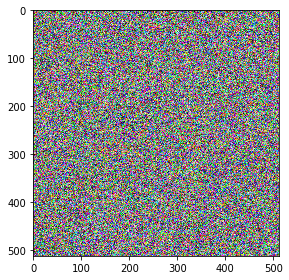

In [25]:
# Generate a random image
x = np.random.rand(*style_shape)
io.imshow(x[0])

In [26]:
generate_result(generator, 10, x, resultspath+'/result/capandles/')

Generated flattened image [ 1.4906395   4.00760903 10.00410001 ...  2.26783492 -0.89776964
 -9.46845139]
Minimum Loss: 7986720.0
Generated flattened image [  2.06543346  11.52613184  16.45821005 ...  -9.06959167 -15.92317064
 -26.45767615]
Minimum Loss: 2699867.5
Generated flattened image [ -0.17775509  13.23447604  22.00386139 ... -10.07792587 -18.1850083
 -30.76433351]
Minimum Loss: 1904978.375
Generated flattened image [ -3.25744906  17.26064015  30.24847678 ... -10.8719586  -19.36927074
 -27.20319737]
Minimum Loss: 1588978.75
Generated flattened image [ -5.19693473  20.63742789  34.32195281 ... -10.16091379 -17.92232411
 -23.17813487]
Minimum Loss: 1418325.5
Generated flattened image [ -6.67564138  23.43855047  36.16022232 ...  -9.29270157 -15.76857062
 -19.88584668]
Minimum Loss: 1306620.25
Generated flattened image [ -7.48112939  24.46467345  36.82138705 ...  -9.04510968 -14.58624773
 -18.77784988]
Minimum Loss: 1237672.875
Generated flattened image [ -7.98623089  24.42718177  35

array([ -7.17996426,  25.37208252,  35.75809865, ...,  -7.49041514,
        -8.69062799, -14.00592321])

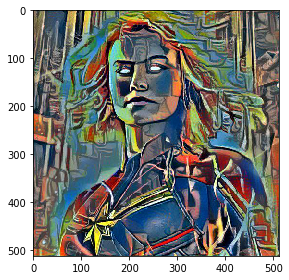

In [27]:
temp = io.imread(resultspath+'/result/capandles/generated_iteration_9.jpg')
io.imshow(temp)